In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import numpy as np

In [2]:
#%%file convergence.py




"""
Debugging convergence in Crocoddyl

"""

from valueNetwork import *
from residualNetwork import *
from dataset import Datagen
from plotTrajectories import plot_trajectories
from terminalUnicycle import ResidualUnicycle
import torch
import crocoddyl
import numpy as np
from unicycle_utils import *


# ddp.th_stop
STOP = 1e-8
# Maxiters 
MAXITERS = 1000


# Residual network trained on x ** 2
resnet = torch.load("rescostNet.pth")


# Random starting position generated from [2.1, 2.1] for x, y and [-2pi, 2pi] for theta
#xyz = np.array([np.random.uniform(-2.1, 2.1),
#                np.random.uniform(-2.1, 2.1),
#                np.random.uniform(-2*np.pi, 2*np.pi)])



xyz = np.array([-1.25739081, -1.96655109, -0.69204187])


model = crocoddyl.ActionModelUnicycle()
terminal_model = ResidualUnicycle(resnet)

model.costWeights = np.matrix([1,1]).T
problem = crocoddyl.ShootingProblem((xyz).T, [ model ] * 30, terminal_model)

ddp = crocoddyl.SolverDDP(problem)

ddp.setCallbacks([crocoddyl.CallbackLogger(), crocoddyl.CallbackVerbose()])
ddp.th_stop = STOP

ddp.solve([] , [], MAXITERS)

mt = problem.terminalModel
dt = problem.terminalData
xt = ddp.xs[-1]


print(dt.Lxx)
print(ddp.iter)

[[ 7.47617531  1.50851595 -3.67467999]
 [ 1.50851595  7.88228607  5.67195368]
 [-3.67467999  5.67195368 34.27651596]]
156


In [3]:
def grid_data(size:int = 70,
              ranges = [-2., 2.]
              ):

    """
    @params:
    size = number of grid points
    @returns:
    grid array        
    """
    min_x, max_x = ranges
    xrange = np.linspace(min_x,max_x,size)
    data = np.array([ [x1,x2, 0.] for x1 in xrange for x2 in xrange ])
    return data

In [4]:
data = grid_data()

In [5]:
cost = resnet(torch.tensor(data, dtype = torch.float32)).detach().numpy()

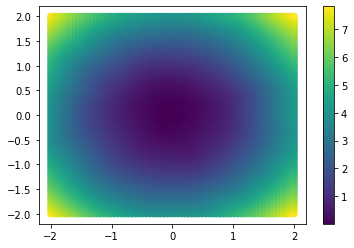

In [6]:
plt.scatter(data[:,0], data[:,1], c = cost)
plt.colorbar()

In [7]:
vx = []
vxx = []
for test in data:
    test = torch.tensor(test, dtype = torch.float32)
    grad1 = resnet.gradient(test).detach().numpy()
    vx.append(grad1[0])



Text(0.5, 1.0, 'Grad[0]')

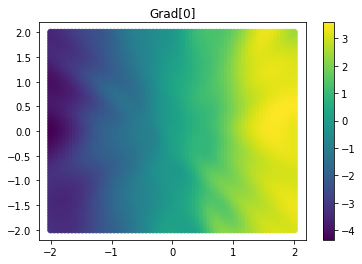

In [8]:
plt.scatter(data[:,0], data[:,1], c = vx)
plt.colorbar()
plt.title("Grad[0]")

In [9]:
def constant_data(constant:float = 0.99):
    print(f"x = {constant}, theta = 0.")
    y = np.linspace(-1., 1., 100)
    test =  np.array([ [constant,x2, 0.] for x2 in y ])
    return test
data = constant_data()

x = 0.99, theta = 0.


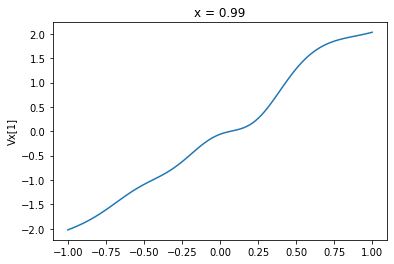

In [17]:
vx = []
vxx = []
for test in data:
    test = torch.tensor(test, dtype = torch.float32)
    grad1 = resnet.gradient(test).detach().numpy()
    vx.append(grad1[1])
    grad2 = resnet.gauss_hessian(test).detach().numpy()
    vxx.append(grad2[1][1])
    
plt.plot(data[:,1], vx)
plt.ylabel("Vx[1]")
plt.title("x = 0.99")
plt.savefig("grad1.png")

Text(0, 0.5, 'Vxx[11]')

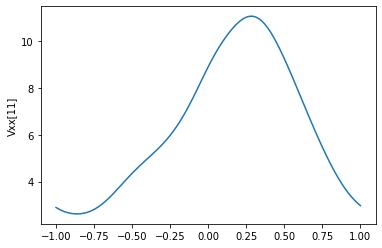

In [14]:

plt.clf()
plt.plot(data[:,1], vxx)
plt.ylabel("Vxx[11]")